In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import re

In [2]:
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Open Sans']
# rcParams['font.weight'] = 'semibold'


my_dpi = 300
name_to_read = '../output/last_output.csv'
FORMAT = re.compile('GeneratedI(\d+)O(\d+)Seed\d+')
MODEL_X_FORMAT = 'Input: {}\nOutput: {}'
model_order = [MODEL_X_FORMAT.format(i, o) for i, o in ((4,2), (8,2), (8,4), (10,2), (12,2), (14,4), (15,5))]

In [3]:
def normalise_data(data):
    data = data.groupby(['Tool', 'Model', 'PhaseName', 'MetricName']).mean().reset_index()
    data.loc[:, 'Model'] = data['Model'].apply(change_model_name)
    data['ModelOrder'] = data.apply(lambda row : model_order.index(row['Model']), axis=1)
    data.sort_values('ModelOrder')
    return data

In [4]:
def read_measurements(file_name=None):
    if file_name is None:
        file_name = name_to_read
    data = pd.read_csv(file_name, delimiter=';')

    # Normalize data
    data = normalise_data(data)

    # Split time and memory data
    load_time_data = data[data['PhaseName'] == 'Load'].copy()
    load_time_data = load_time_data[load_time_data['MetricName'] == 'Time']
    run_time_data = data[data['MetricName'] == 'Time'].copy()
    run_time_data = run_time_data[run_time_data['PhaseName'] == 'Run']
    
    time_data = data.copy()
    time_data = time_data[time_data['PhaseName'] != 'Initialization']
    
    time_data = time_data[time_data['MetricName'] == 'Time']
    time_data = time_data.groupby(['Tool', 'Model', 'MetricName','ModelOrder']).aggregate({'MetricValue': 'sum'}).reset_index()
    
    
    nodes_data = data[data['MetricName'] == 'DecisionNodes'].copy()
    time_data.loc[:, 'MetricValue'] = time_data['MetricValue'] / 10e6
    
    load_time_data.loc[:, 'MetricValue'] = load_time_data['MetricValue'] / 10e6
    run_time_data.loc[:, 'MetricValue'] = run_time_data['MetricValue'] / 10e6

#    data['value'] = data['MetricValue'] / 10e6
    return (time_data, load_time_data, run_time_data, nodes_data)

In [5]:
def change_model_name(old_name):
    match = FORMAT.match(old_name)
    if match:
        return MODEL_X_FORMAT.format(*match.groups())
    return old_name

In [13]:
good_colors = ['#000000','#e69f00','#56b4e9','#009e73','#f0e442','#0072b2','#d55e00','#cc79a7']
good_shapes = ['o', 's', 'v', '^', 'x']
good_dashes = ['-', '--', ':', '-.']

info = {
    'EMFSolutionATL':               (good_colors[0], good_shapes[0], good_dashes[0], 'ATL BDT'),
    'RSyncBDD':     (good_colors[2], good_shapes[2], good_dashes[0], 'RSYNC ordered BDD'),
    'RSyncBDD-Unordered':    (good_colors[3], good_shapes[3], good_dashes[0], 'RSYNC unordered BDD'),
    'RSyncBDT':    (good_colors[4], good_shapes[3], good_dashes[0], 'RSYNC ordered BDT'),
    'RSyncBDT-Unordered':   (good_colors[5], good_shapes[3], good_dashes[0], 'RSYNC unordered BDT')
}

In [14]:
def reformat(data, tools):
    ids = data['ModelOrder'].unique()
    new_data = pd.DataFrame(data=None, index=ids, columns=['Model'] + sorted(tools))
    new_data['Model'] = data['Model'].unique()
    #new_data['ModelOrder'] = time_data['ModelOrder'].unique()

    for tool in tools:
        data_for_tool = data[data['Tool'] == tool]
        for model_id in ids:
            try:
                value = data_for_tool[data_for_tool['ModelOrder'] == model_id]['MetricValue'].item()
                # at[row, column] = value
                new_data.at[model_id, tool] = value
            except:
                pass
    new_data.sort_index(inplace=True)
    return new_data

In [15]:
def draw_bar(data, axis_title, colors, logY, output_name, plotLegend):
    fig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)
    ax1 = fig.add_subplot(111)
    if logY:
        ax1.set_yscale('log')
    #else:
    #    ax1.set_ylim(0, 1.19 * data['MetricValue'].max())
    data.plot(x="Model", y=sorted(data.columns[1:]), kind="bar", ax=ax1, color=colors,
                  label=[info[key][3] for key in sorted(data.columns[1:])])
    ax1.set_xlabel('Model instance',weight='semibold',name='Open Sans')
    ax1.set_ylabel(axis_title, weight='semibold',name='Open Sans')
    if plotLegend:
        legend = ax1.legend(bbox_to_anchor=(0.5, 1.8), loc='upper center', ncol=3)
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(output_name + '.png', format="png", dpi=fig.dpi, bbox_inches=bbox)
    else:
        ax1.legend().set_visible(False)
        plt.tight_layout()
        fig.savefig(output_name + '.pdf', format="pdf", dpi=fig.dpi, bbox_inches="tight")
        fig.savefig(output_name + '.png', format="png", dpi=fig.dpi, bbox_inches="tight")

In [16]:
time_data, load_time_data, run_time_data, nodes_data = read_measurements()

load_time_data = reformat(load_time_data, list(info))
run_time_data = reformat(run_time_data, list(info))
time_data = reformat(time_data, list(info))
nodes_data = reformat(nodes_data, [tool for tool in info if 'ATL' not in tool])
values = nodes_data.drop('Model', axis=1)
nodes_data.loc[:, nodes_data.columns != 'Model'] = values.div(values.max(axis=1), axis=0)


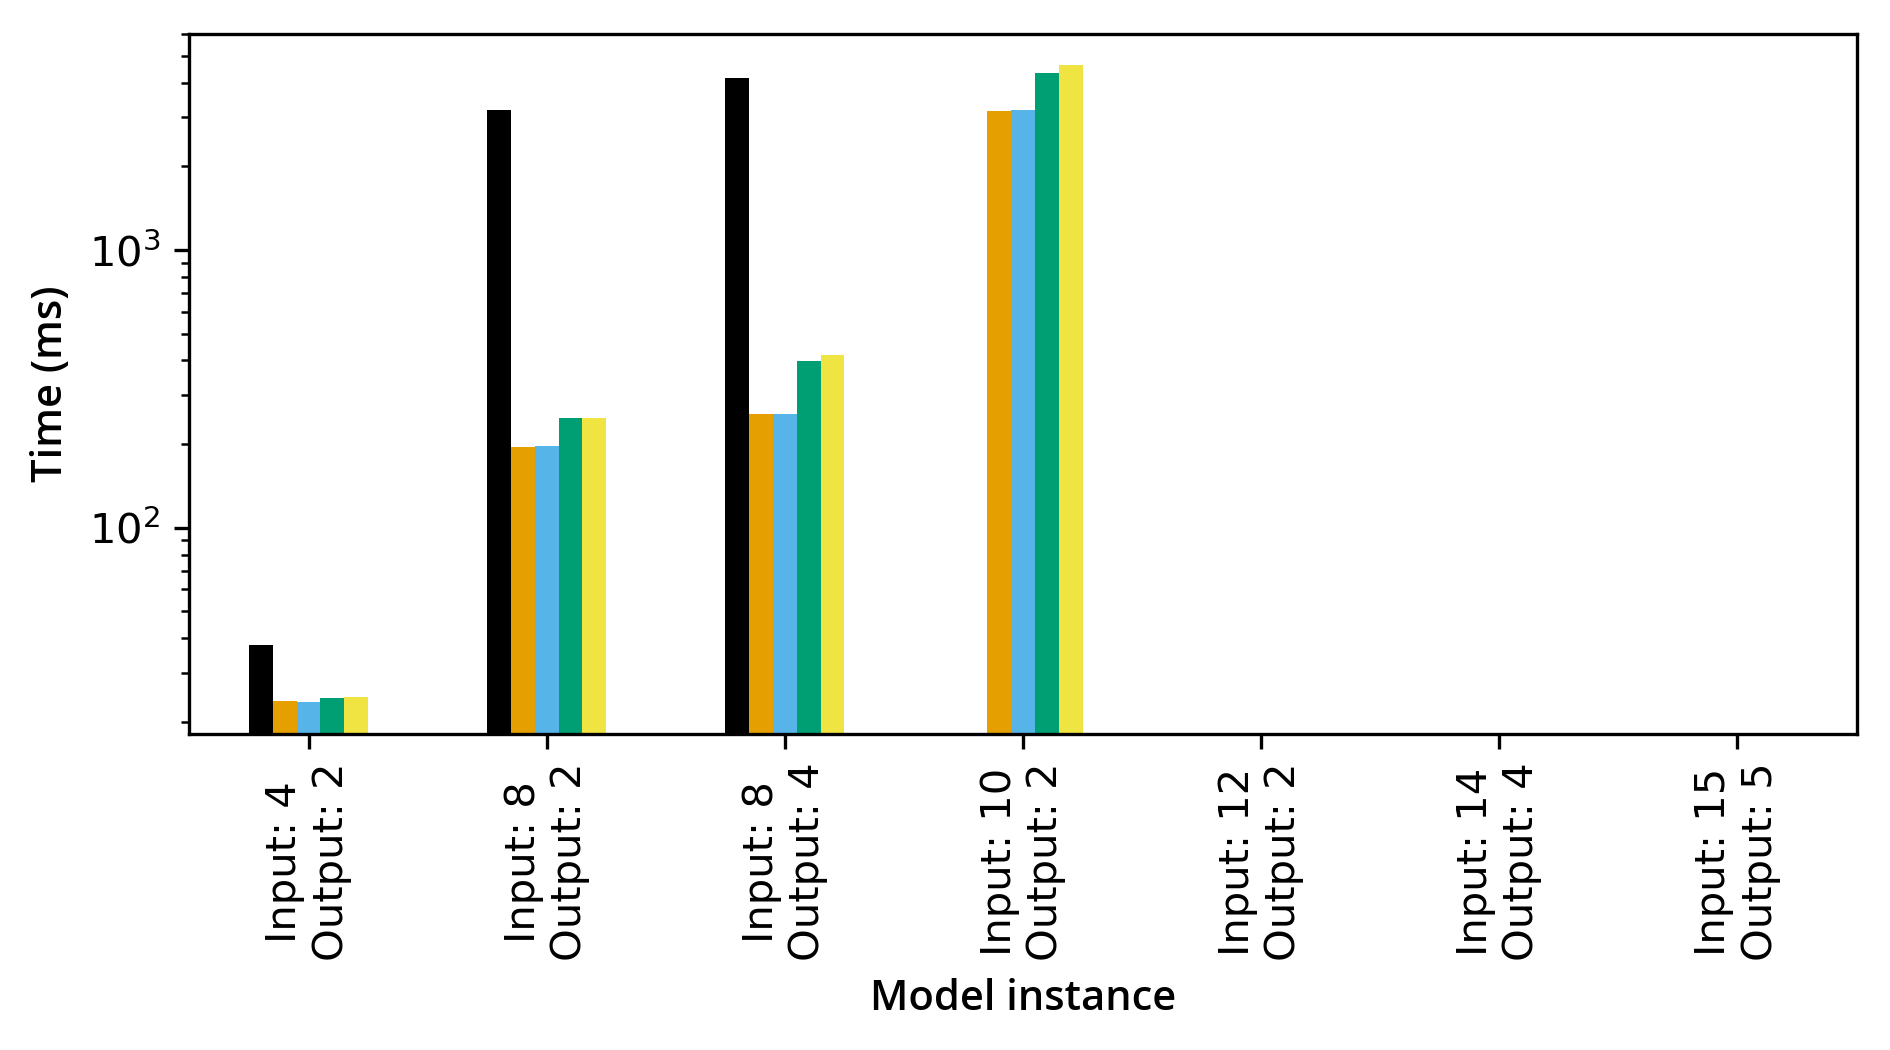

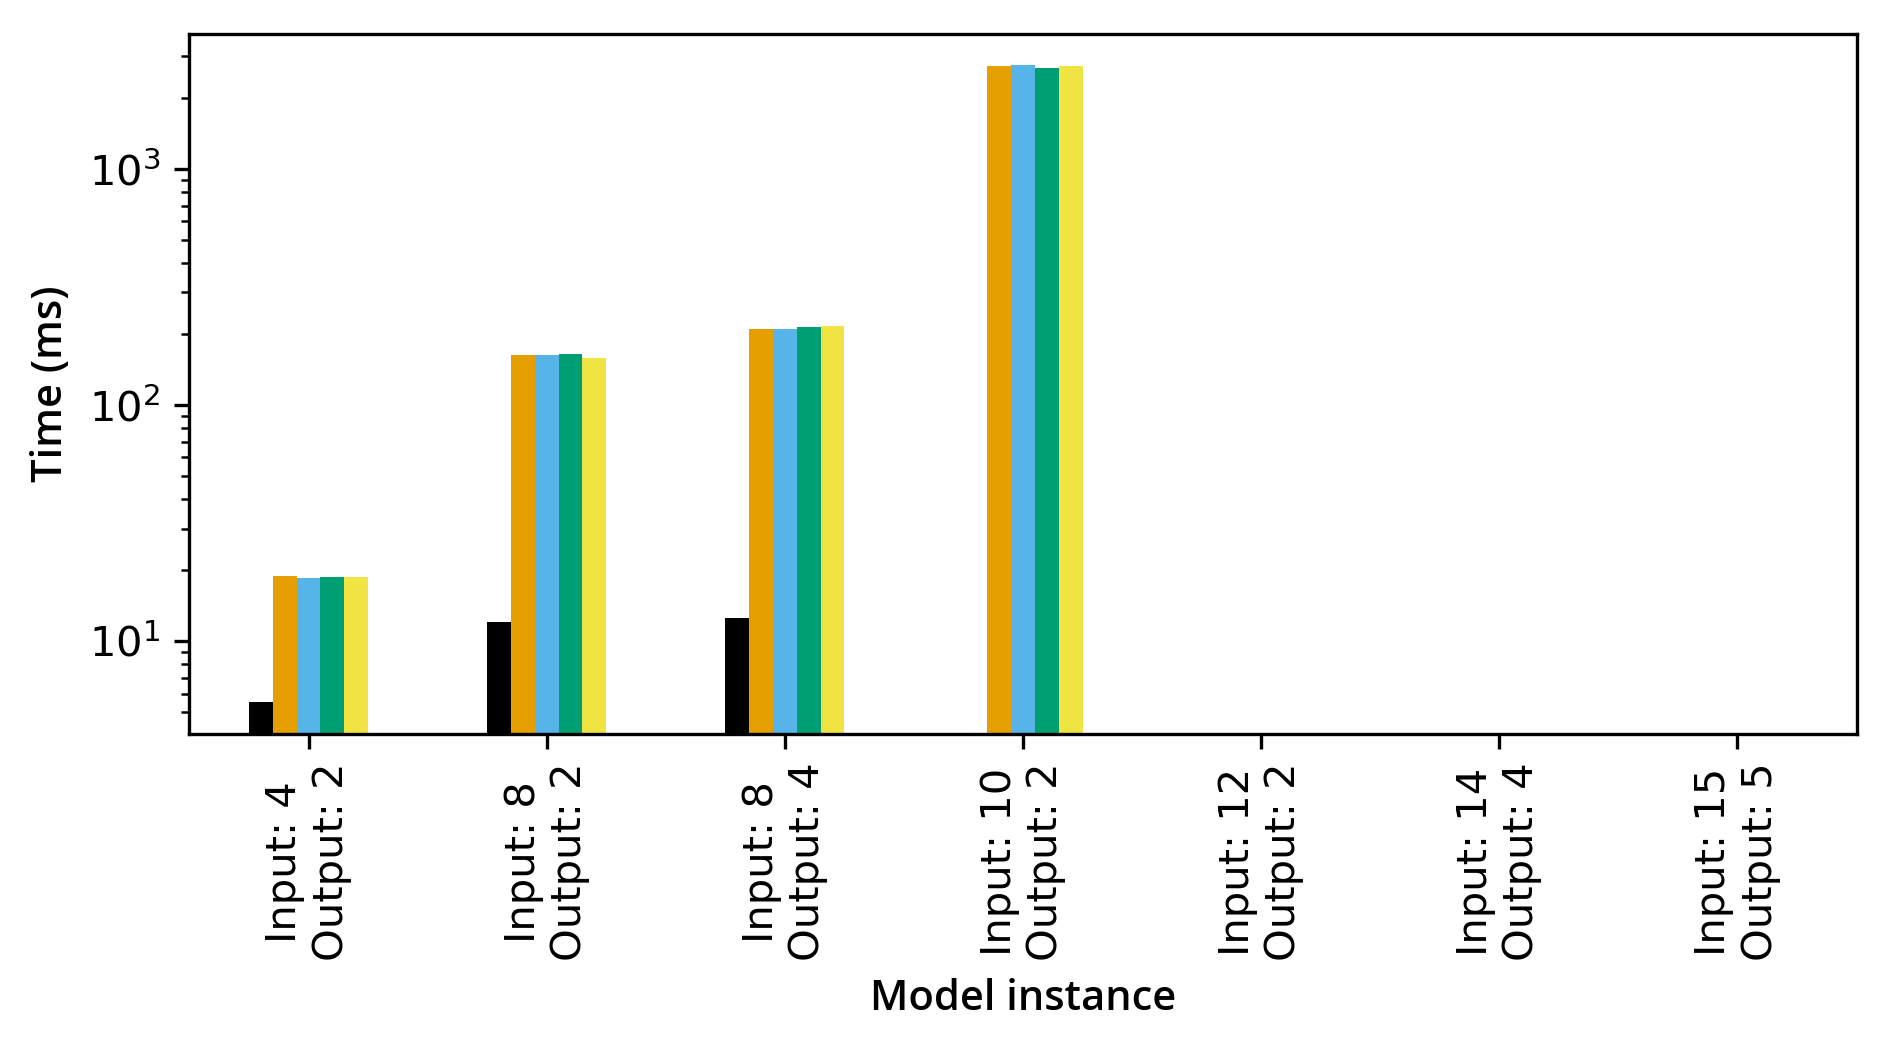

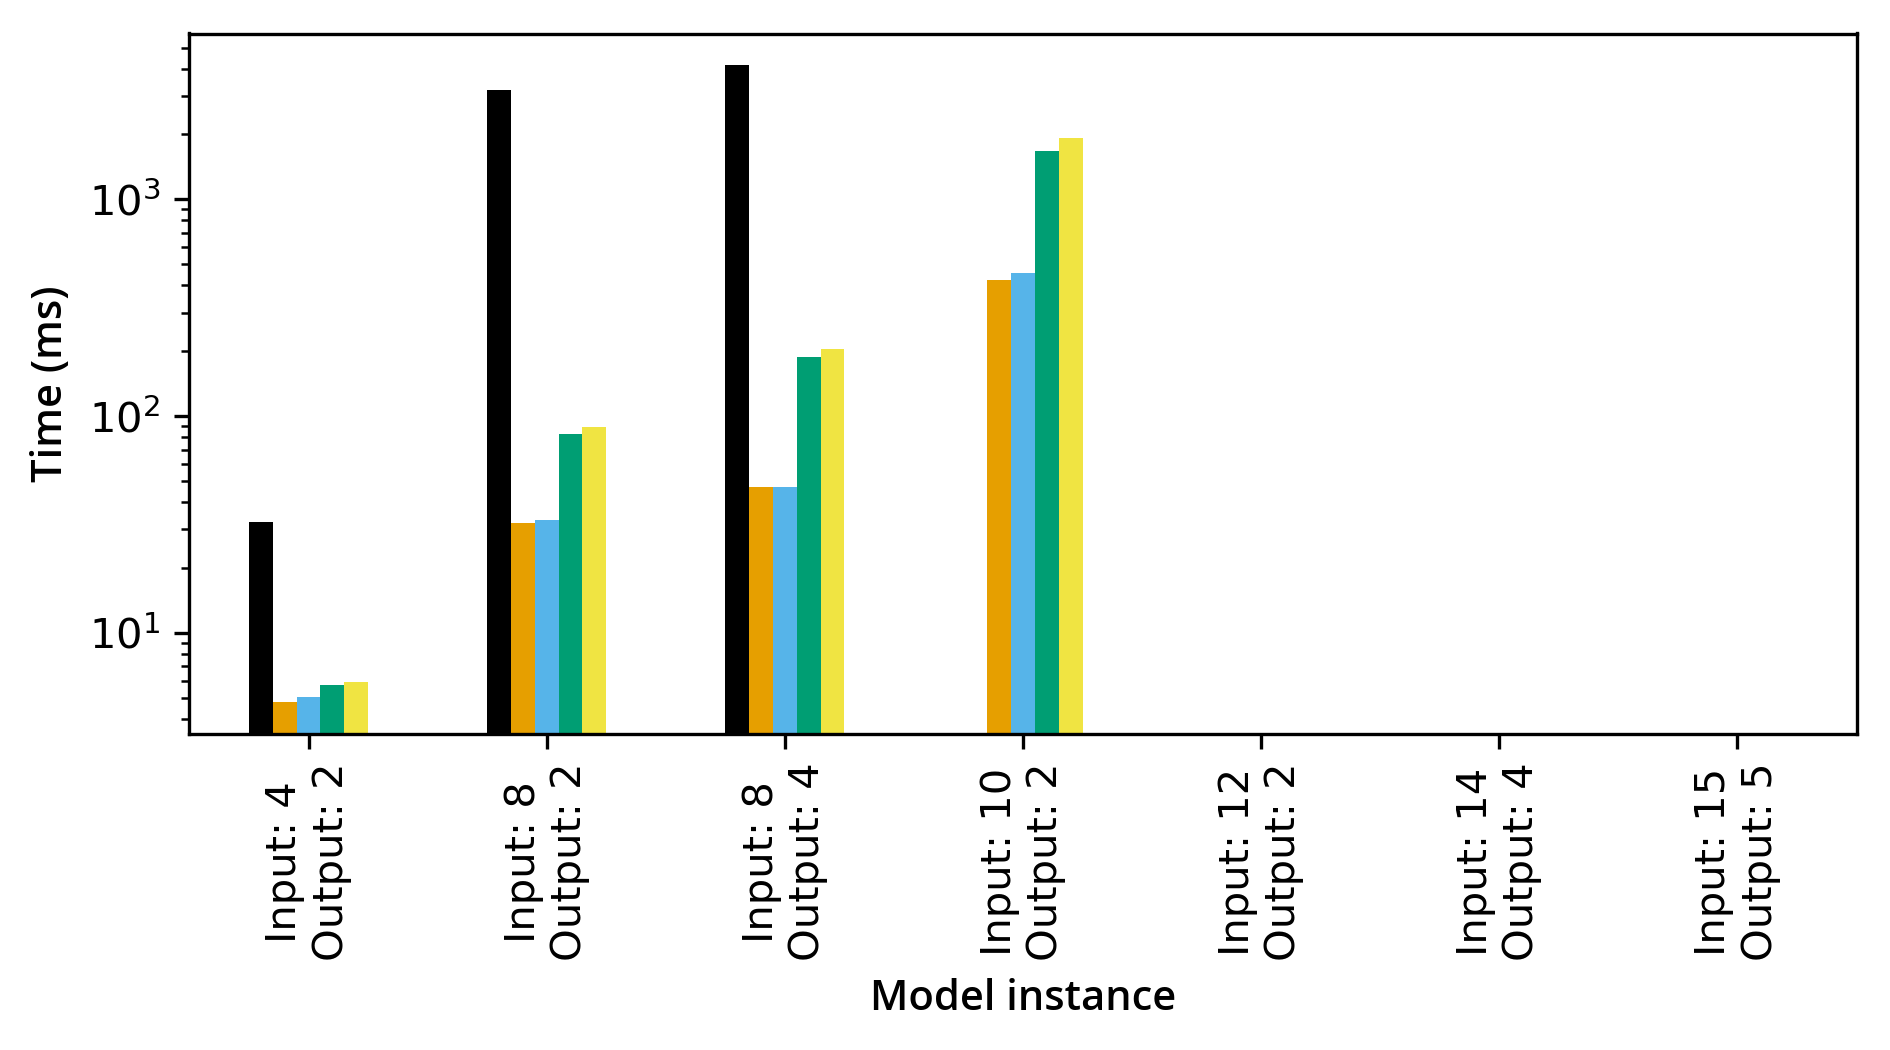

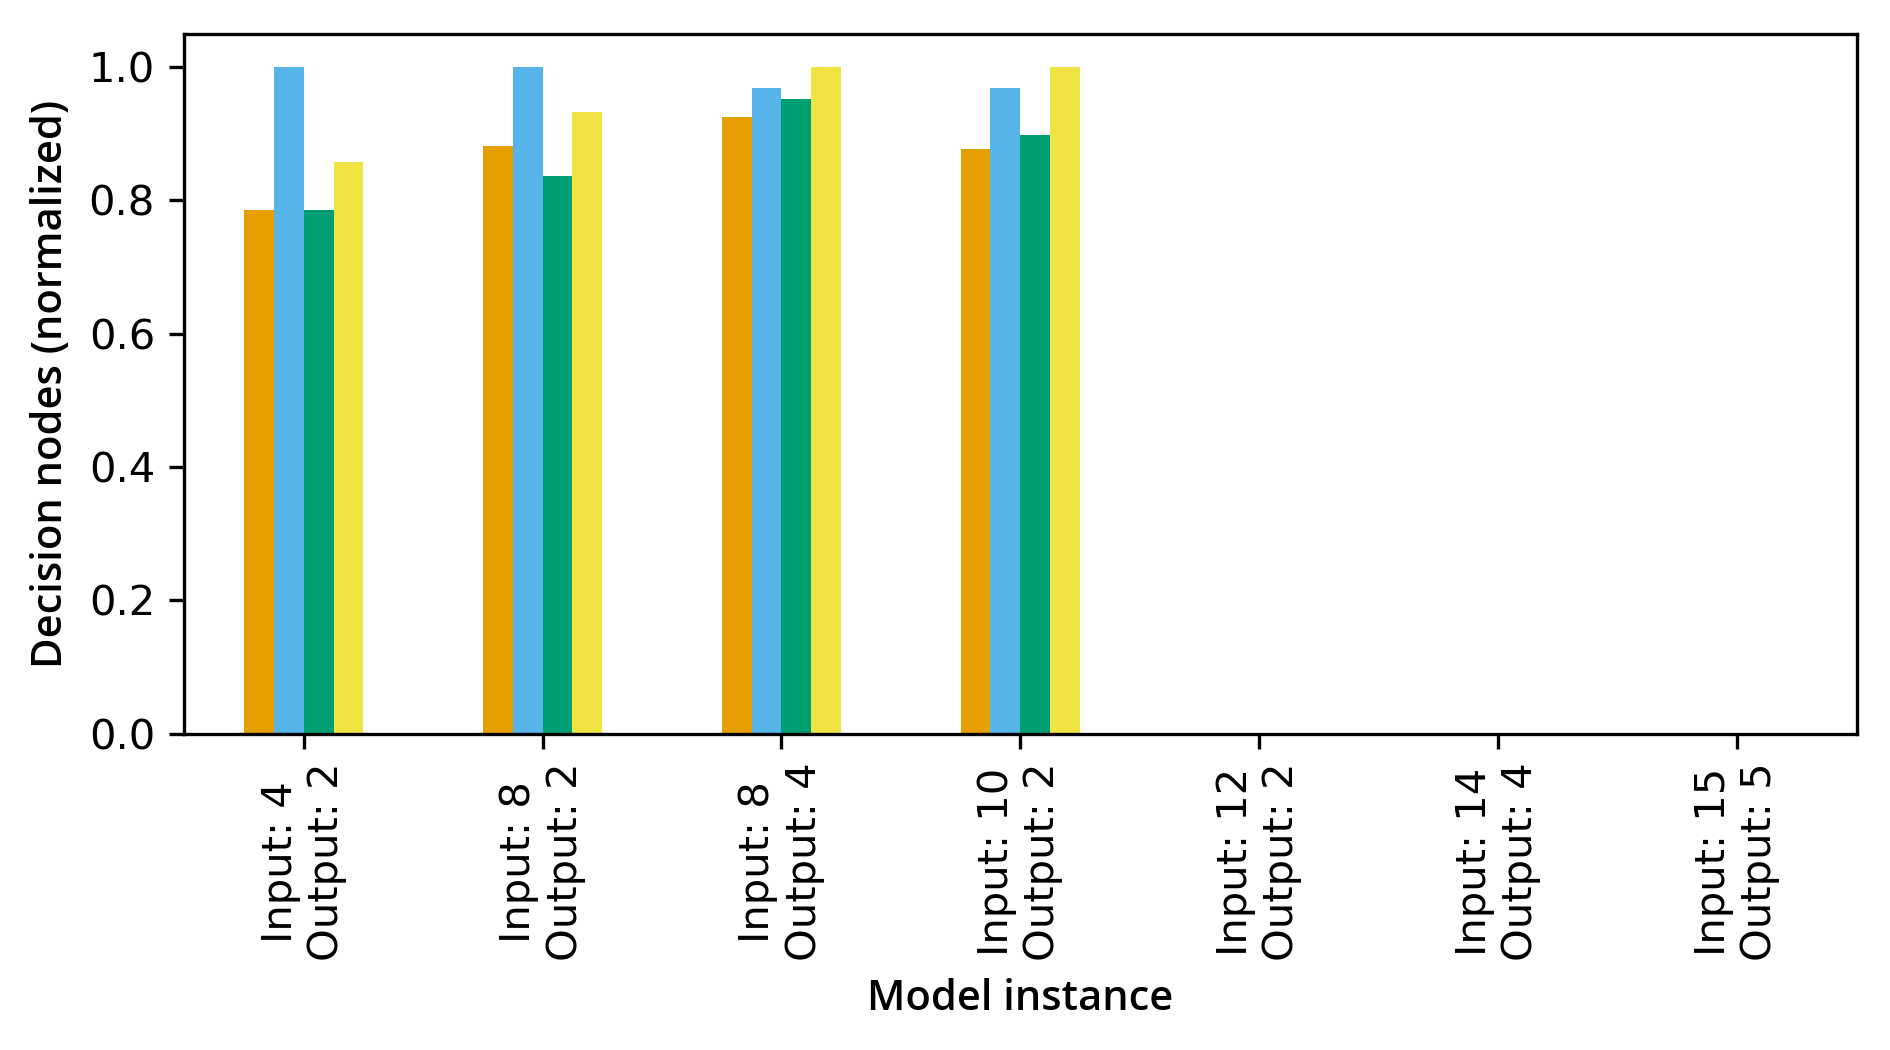

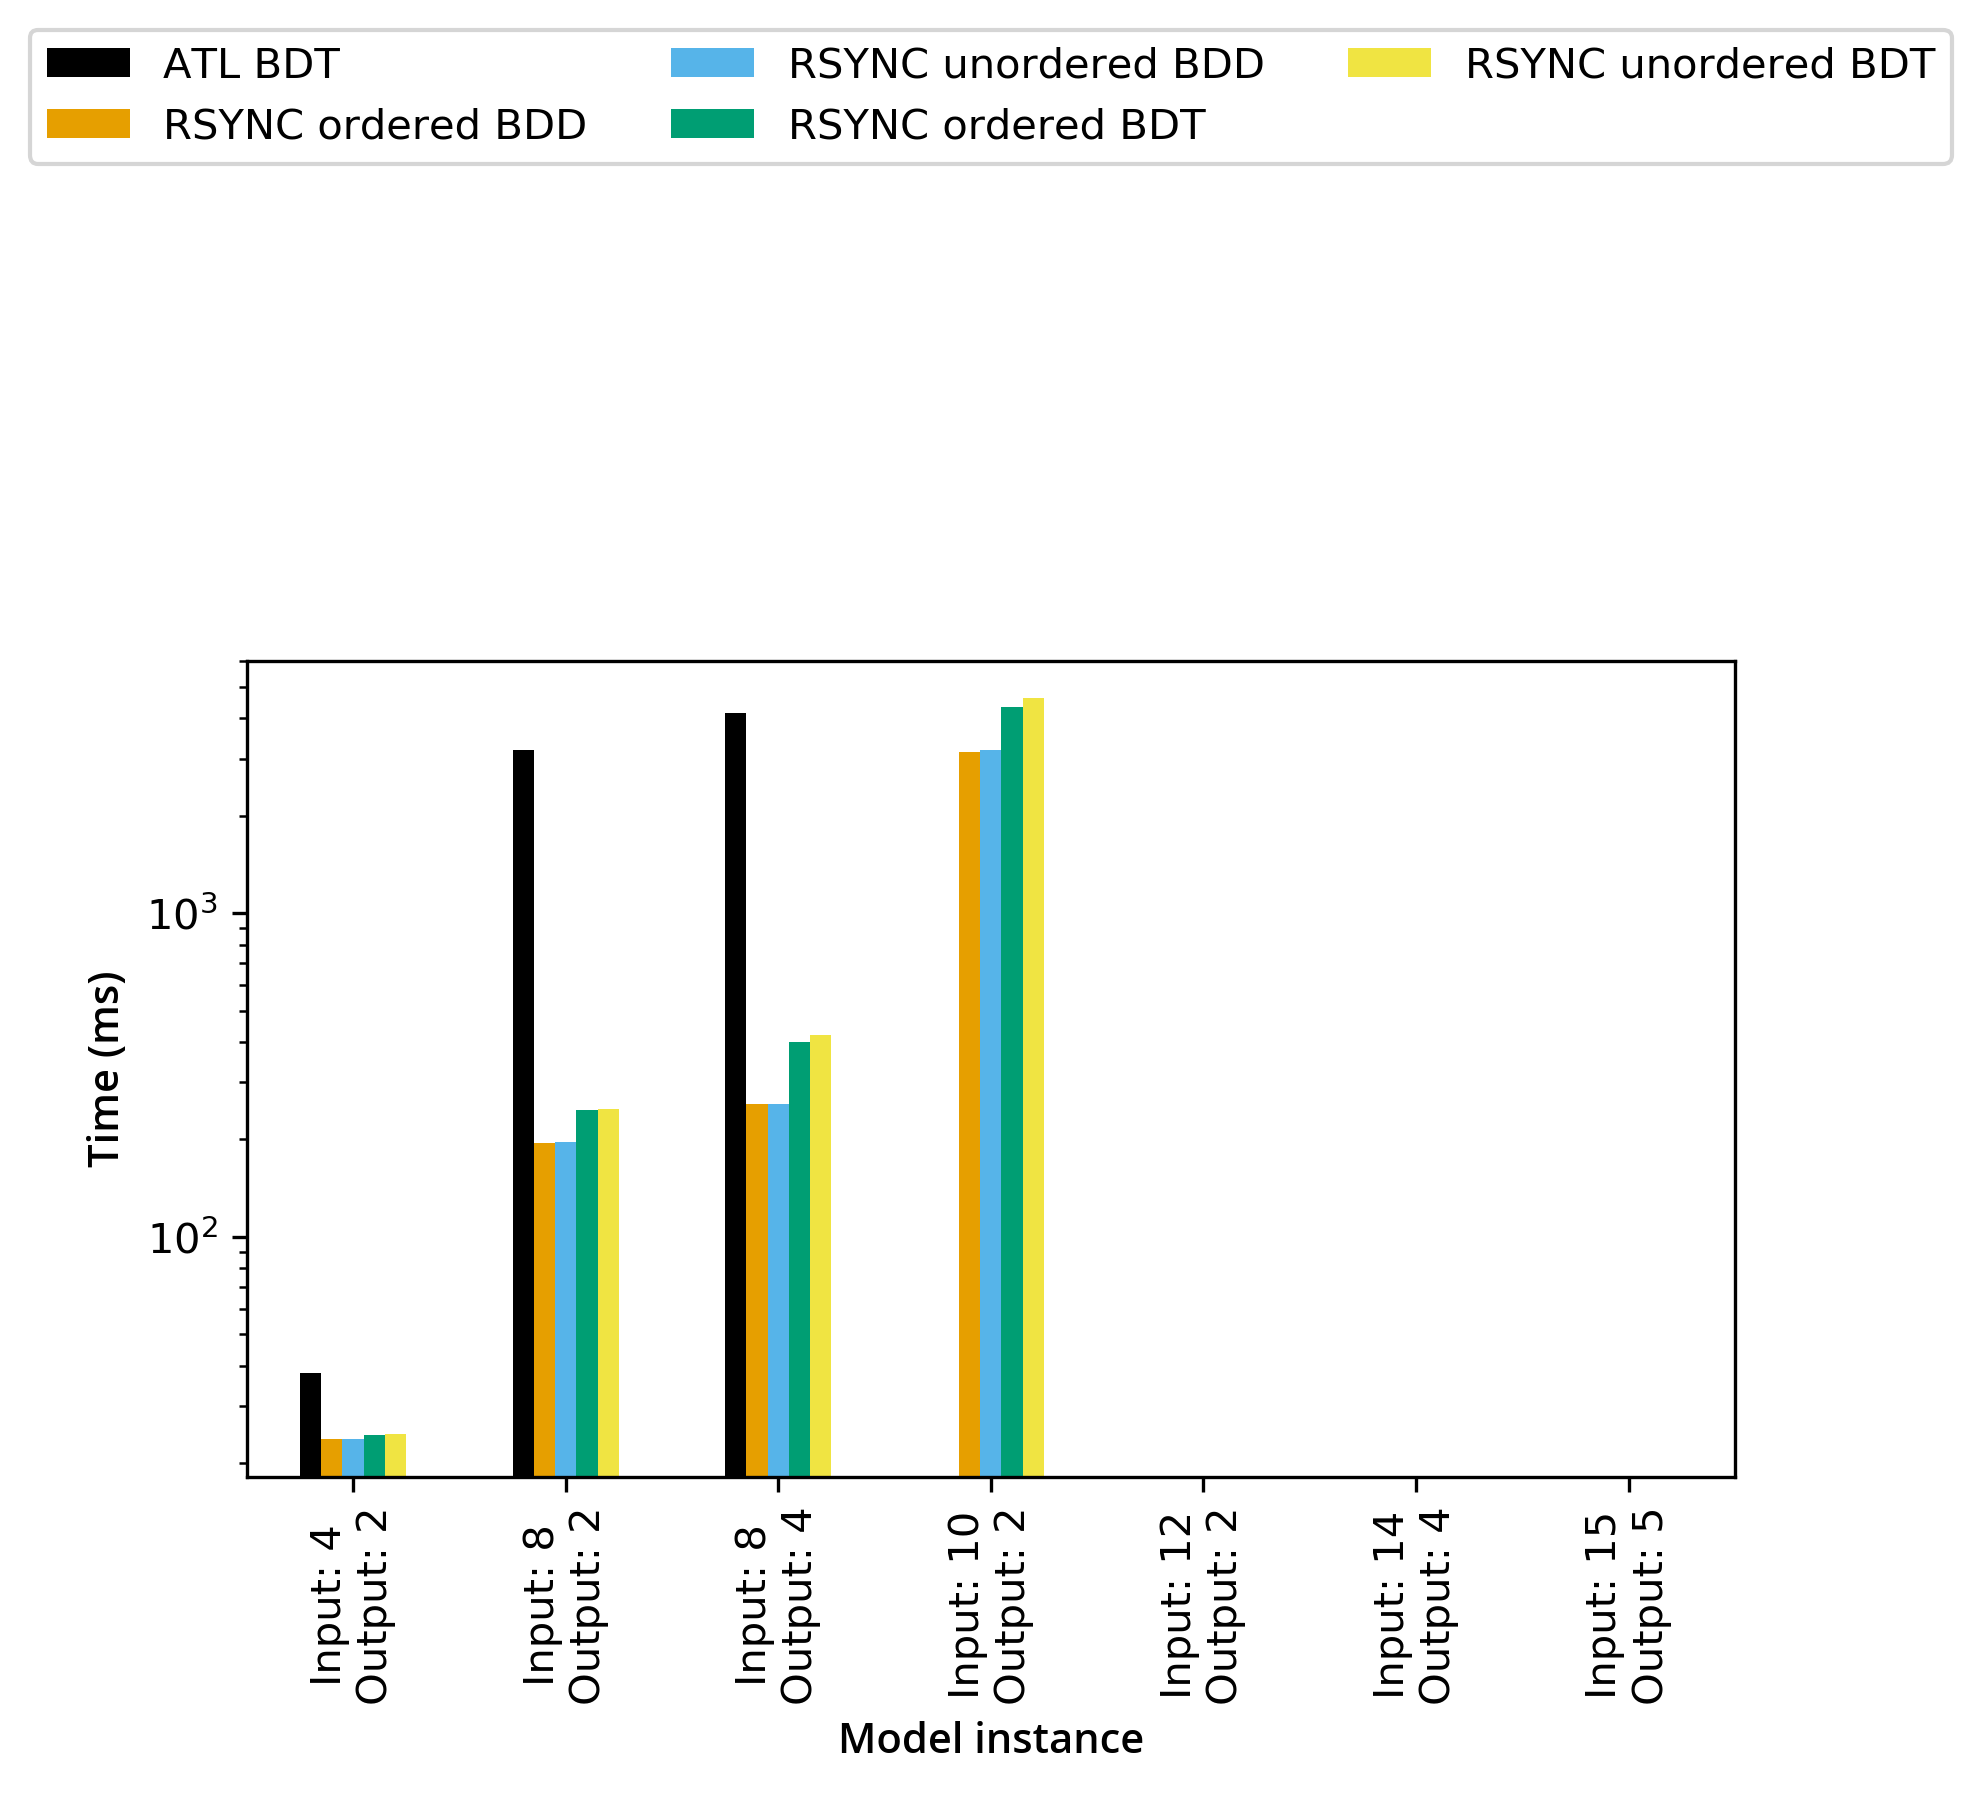

In [18]:
draw_bar(time_data, 'Time (ms)', good_colors, True, 'role-total_time',False)
draw_bar(load_time_data, 'Time (ms)', good_colors, True, 'role-load_time',False)
draw_bar(run_time_data, 'Time (ms)', good_colors, True, 'role-run_time',False)
# assumption ATL is at first place, thus leave out first color
draw_bar(nodes_data, 'Decision nodes (normalized)', good_colors[1:], False, 'role-nodes',False)
draw_bar(time_data, 'Time (ms)', good_colors, True, 'role-legend', True)